# **Gaussian Process Regression**

## **[OVERVIEW]**

**Step 1: Define Gaussian RBF** <br>
We start by defining the kernel function to be used in our Gaussian Process model. This part should be a quick review from "Linear Regression". <br><br>
**Step 2: Random Data Generation** <br>
We predefine some function as the true function. We then create random samples by adding Gaussian noise. <br><br>
**Step 3: Prior Distribution Visualization** <br>
We take a look at how the unconditioned Gaussian process model looks like. <br><br>
**Step 4: Posterior Distribution Visualization** <br>
Given some random samples (training data), we visualize how the conditioned Gaussian process model looks like. <br><br>
**Step 5: Optimization of Hyperparameters** <br>
We redefine everything done from steps 1 through 4 with PyTorch instead of Numpy. Next, through backpropagation (gradient descent algorithm) we optimize the hyperparameters that define the Gaussian Process model.<br><br>
**EXTRA: Easy Implementation with Scikit-Learn**<br>
We realize that using scikit-learn's module, steps 1~5 can be implemented fairly easily.

## [STEP 1] Defining the Gaussian radial basis function (Gaussian rbf)

In [1]:
# Import useful libraries!
import torch
import numpy as np
import matplotlib.pyplot as plt

### Role of kernels

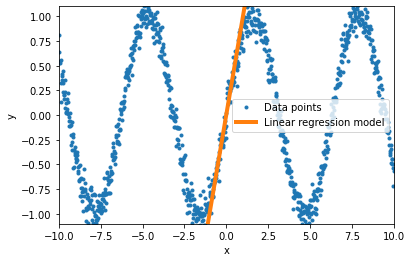

In [2]:
x = np.linspace(-10, 10, 1000)
y = np.sin(x) + np.random.normal(scale=0.1, size=1000)
a = 1
y_pred = a * x
plt.plot(x, y, '.', label='Data points')
plt.plot(x, y_pred, linewidth=4.0, label='Linear regression model')
plt.xlim([-10, 10])
plt.ylim([-1.1, 1.1])
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

Define $f(\textbf{x})=\sin{\textbf{x}}$

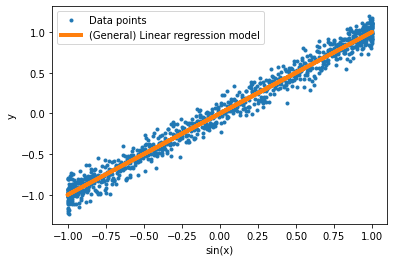

In [3]:
f_x = np.sin(x)
y_pred_with_f = a * f_x
plt.plot(f_x, y, '.', label='Data points')
plt.plot(f_x, y_pred_with_f, linewidth=4.0, label='(General) Linear regression model')
plt.xlabel('sin(x)')
plt.ylabel('y')
plt.legend()
plt.show()

Define $\phi(\textbf{x})=\sigma^2_f\exp{\left(-\frac{1}{2l^2}\left(\textbf{x}-\mu\right)^2\right)}$

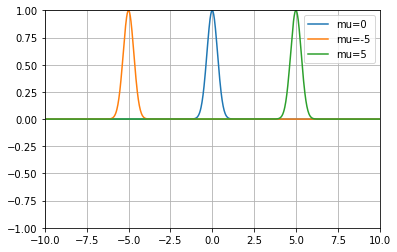

In [4]:
mu1 = 0
mu2 = -5
mu3 = 5
sigma_f_squared = 1.0
l_squared = 0.1
x = np.linspace(-10, 10, 1000)
phi1 = sigma_f_squared * np.exp(-np.square(x-mu1) / (2*l_squared))
phi2 = sigma_f_squared * np.exp(-np.square(x-mu2) / (2*l_squared))
phi3 = sigma_f_squared * np.exp(-np.square(x-mu3) / (2*l_squared))
plt.plot(x, phi1, label='mu={}'.format(mu1))
plt.plot(x, phi2, label='mu={}'.format(mu2))
plt.plot(x, phi3, label='mu={}'.format(mu3))
plt.legend()
plt.grid()
plt.xlim([-10, 10])
plt.ylim([-1, 1])
plt.show()

### Gaussian RBF
Radial basis function for two vectors of same dimension $\textbf{x}_i, \textbf{x}_j\in\mathbb{R}^d$
\begin{equation}
K(\textbf{x}_i, \textbf{x}_j) = 
\sigma^2_f \exp{\left( -\frac{1} {2l^2}(\textbf{x}_i-\textbf{x}_j)^T(\textbf{x}_i-\textbf{x}_j)\right)} \\
= 
\sigma^2_f \exp{\left( -\frac{1} {2l^2}(\textbf{x}_i^T\textbf{x}_i-2\textbf{x}_i^T\textbf{x}_j+\textbf{x}_j^T\textbf{x}_j)\right)}
\end{equation}

In [5]:
# Kernel definitions
def vanilla_gaussian_rbf(x1, x2, l=1, sigma_f=1):
    assert x1.shape[1] == 1 and x2.shape[1] == 1
    xiTxi = np.dot(x1.T, x1).reshape(1)
    xiTxj = np.dot(x1.T, x2).reshape(1)
    xjTxj = np.dot(x2.T, x2).reshape(1)
    dist_matrix = xiTxi - 2*xiTxj + xjTxj
    return (sigma_f**2) * np.exp((-1/(l**2)) * dist_matrix)

# TEST
x1 = np.zeros((10, 1))
x2 = np.zeros((10, 1))
out = vanilla_gaussian_rbf(x1, x2)
print(out)

[1.]


Radial basis function between two matrices $\textbf{X}\in\mathbb{R}^{m\times d}, \textbf{Y}\in\mathbb{R}^{n \times d}$
\begin{equation}
K(\textbf{X}, \textbf{Y}) = 
\begin{bmatrix}
K(\textbf{x}_1, \textbf{y}_1) & K(\textbf{x}_1, \textbf{y}_2) & \cdots & K(\textbf{x}_1, \textbf{y}_n)\\
K(\textbf{x}_2, \textbf{y}_1) & K(\textbf{x}_2, \textbf{y}_2) & \cdots & K(\textbf{x}_2, \textbf{y}_n)\\
\vdots & \vdots & \ddots & \vdots\\
K(\textbf{x}_m, \textbf{y}_1) & K(\textbf{x}_m, \textbf{y}_2) & \cdots & K(\textbf{x}_m, \textbf{y}_n)
\end{bmatrix} \\
= \sigma_f^2\exp{\left(-\frac{1}{2l^2}
\begin{bmatrix}
(\textbf{x}_1^T\textbf{x}_1-2\textbf{x}_1^T\textbf{y}_1+\textbf{y}_1^T\textbf{y}_1) & (\textbf{x}_1^T\textbf{x}_1-2\textbf{x}_1^T\textbf{y}_2+\textbf{y}_2^T\textbf{y}_2) & \cdots & (\textbf{x}_1^T\textbf{x}_1-2\textbf{x}_1^T\textbf{y}_n+\textbf{y}_n^T\textbf{y}_n)\\
(\textbf{x}_2^T\textbf{x}_2-2\textbf{x}_2^T\textbf{y}_1+\textbf{y}_1^T\textbf{y}_1) & (\textbf{x}_2^T\textbf{x}_2-2\textbf{x}_2^T\textbf{y}_2+\textbf{y}_2^T\textbf{y}_2) & \cdots & (\textbf{x}_2^T\textbf{x}_2-2\textbf{x}_2^T\textbf{y}_n+\textbf{y}_n^T\textbf{y}_n)\\
\vdots & \vdots & \ddots & \vdots\\
(\textbf{x}_m^T\textbf{x}_m-2\textbf{x}_m^T\textbf{y}_1+\textbf{y}_1^T\textbf{y}_1) & (\textbf{x}_m^T\textbf{x}_m-2\textbf{x}_m^T\textbf{y}_2+\textbf{y}_2^T\textbf{y}_2) & \cdots & (\textbf{x}_m^T\textbf{x}_m-2\textbf{x}_m^T\textbf{y}_n+\textbf{y}_n^T\textbf{y}_n)
\end{bmatrix}
\right)}
\end{equation}

NOTE: Distance matrix can be computed as follows using Python's (Numpy's) broadcasting method!
\begin{equation}
\begin{bmatrix}
\textbf{x}_1^T\textbf{x}_1 \\
\textbf{x}_2^T\textbf{x}_2 \\
\vdots \\
\textbf{x}_m^T\textbf{x}_m
\end{bmatrix}
-2
\begin{bmatrix}
\textbf{x}_1^T\textbf{y}_1 & \textbf{x}_1^T\textbf{y}_2 & \cdots & \textbf{x}_1^T\textbf{y}_n \\
\textbf{x}_2^T\textbf{y}_1 & \textbf{x}_2^T\textbf{y}_2 & \cdots & \textbf{x}_2^T\textbf{y}_n \\
\vdots & \vdots & \ddots & \vdots \\
\textbf{x}_m^T\textbf{y}_1 & \textbf{x}_m^T\textbf{y}_2 & \cdots & \textbf{x}_m^T\textbf{y}_n
\end{bmatrix}
+
\begin{bmatrix}
\textbf{y}_1^T\textbf{y}_1 & \textbf{y}_2^T\textbf{y}_2 & \cdots & \textbf{y}_n^T\textbf{y}_n
\end{bmatrix}
\end{equation}

In [6]:
def gaussian_rbf(X, Y, l=1, sigma_f=1):
    assert X.shape[1] == Y.shape[1] # dimension must be equal!
    m, d = X.shape
    n, d = Y.shape
    term1 = np.sum(X**2, axis=1).reshape(-1, 1)
    assert term1.shape == (m, 1)
    term2 = np.dot(X, Y.T)
    assert term2.shape == (m, n)
    term3 = np.sum(Y**2, axis=1).reshape(1, -1)
    assert term3.shape == (1, n)
    dist_matrix = term1 - 2*term2 + term3
    return (sigma_f**2) * np.exp((-1/(l**2)) * dist_matrix)

# TEST
X = np.zeros((5, 5))
Y = np.zeros((5, 5))
out = gaussian_rbf(X, Y)
print(out)

[[1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]]


## [STEP 2] Random Data Generation

Suppose true data is defined as follows: 
\begin{equation}
f(x) = \sin(x)+0.05x^2
\end{equation}

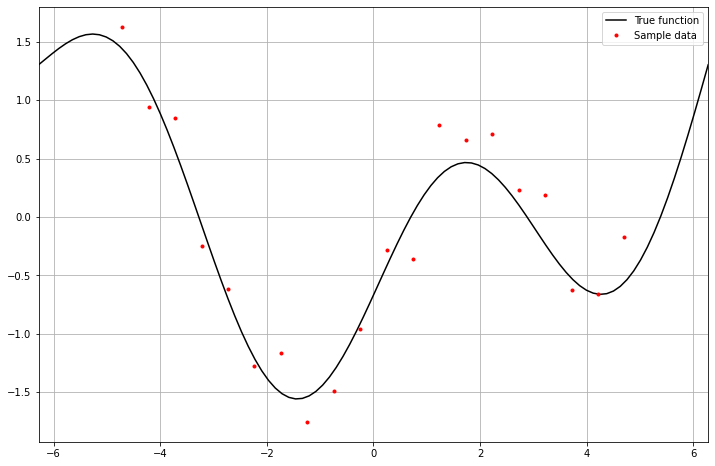

In [7]:
def true_function(x):
    return np.sin(x) + 0.05 * (x ** 2)

# True function
x_true = np.linspace(-2*np.pi, 2*np.pi, 100) # 100 data points between -2pi and 2pi
y_true = true_function(x_true)
y_mean = np.mean(y_true)
y_true -= y_mean # We are assuming an expected value of 0 from our prior distribution for simplicity, so just offset all values by the mean value

# Sample data
n = 20
x_data = np.linspace(-1.5*np.pi, 1.5*np.pi, n)
random_noise = 0.3 * np.random.randn(n) # assume sampled data has some noise
y_data = true_function(x_data) + random_noise
y_data -= y_mean # offset by same mean from real data!

# Plot true function with sampled data points
plt.figure(figsize=(12, 8))
plt.plot(x_true, y_true, 'k-', label='True function')
plt.plot(x_data, y_data, 'r.', label='Sample data')
plt.legend()
plt.grid()
plt.xlim([-2*np.pi, 2*np.pi])
plt.show()

## [STEP 3] Prior Distribution Visualization

Prior distribution (before learning from data points) given as follows:
\begin{equation}
\textbf{f}\sim\mathcal{N}(0, K(\textbf{X}, \textbf{X}))
\end{equation}

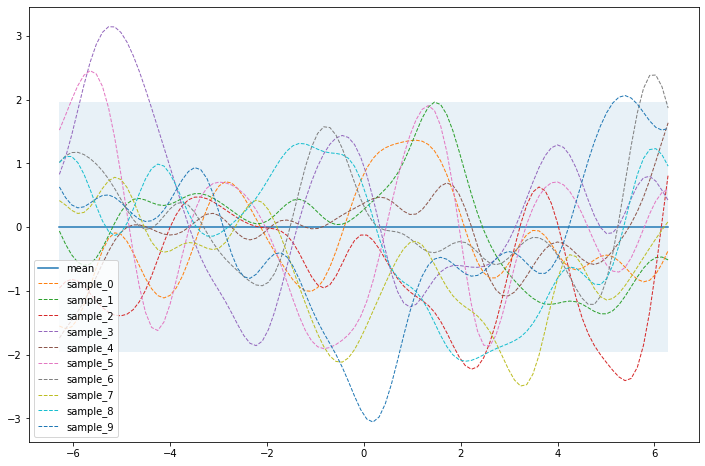

In [8]:
# Prior distribution
X = x_true.reshape(-1, 1)
mu = np.zeros(X.shape[0])
cov = gaussian_rbf(X, X)
samples = np.random.multivariate_normal(mu.reshape(-1), cov, 10)

def plot_gp(mu, cov, X, samples=[]):
    # Assumes data points are 1-dimensional!
    X = X.reshape(-1)
    mu = mu.reshape(-1)
    # 95% confidence interval
    uncertainty = 1.96 * np.sqrt(np.diag(cov))
    plt.fill_between(X, mu+uncertainty, mu-uncertainty, alpha=0.1)
    plt.plot(X, mu, label='mean')
    for i, sample in enumerate(samples):
        plt.plot(X, sample, lw=1, ls='--', label='sample_{}'.format(i))
    plt.legend()

plt.figure(figsize=(12, 8))
plot_gp(mu, cov, X, samples)

## [STEP 4] Posterior Distribution Visualization

Given sampled data points, we can obtain the posterior distribution as follows:
\begin{equation}
\begin{bmatrix}
\textbf{f} \\ \textbf{f}_*
\end{bmatrix}
\sim\mathcal{N}\left(0, 
\begin{pmatrix}
K(\textbf{X}, \textbf{X}) & K(\textbf{X}, \textbf{X}_*) \\
K(\textbf{X}_*, \textbf{X}) & K(\textbf{X}_*, \textbf{X}_*)
\end{pmatrix}
\right)
\end{equation}
For simplicity let's denote the matrices as follows:
\begin{equation}
\begin{bmatrix}
\textbf{f} \\ \textbf{f}_*
\end{bmatrix}
\sim\mathcal{N}\left(0, 
\begin{pmatrix}
K_{11} & K_{12} \\
K_{21} & K_{22}
\end{pmatrix}
\right)
\end{equation}

Then, the conditional distribution of these jointly Gaussian random vectors is given as follows:
\begin{equation}
\textbf{f}_* \mid \textbf{X}_*, \textbf{X}, \textbf{f} \sim\mathcal{N}\left(
    K_{21}K_{11}^{-1}\textbf{f} \quad, \quad 
    K_{22}-K_{21}K_{11}^{-1}K_{12}\right)
\end{equation}

If we assume that sampled data points are noisy, i.e., 
\begin{equation}
y(x)=f(x) + \epsilon \quad, \quad \epsilon\sim\mathcal{N}(0, \sigma_y^2)
\end{equation}
Then, the joint Gaussian can be represented as follows:
\begin{equation}
\begin{bmatrix}
\textbf{y} \\ \textbf{f}_*
\end{bmatrix}
\sim\mathcal{N}\left(0, 
\begin{pmatrix}
K(\textbf{X}, \textbf{X})+\sigma_y^2\mathbb{I} & K(\textbf{X}, \textbf{X}_*) \\
K(\textbf{X}_*, \textbf{X}) & K(\textbf{X}_*, \textbf{X}_*)
\end{pmatrix}
\right)
\end{equation}
And thus, the conditional distribution is as follows:
\begin{equation}
\textbf{f}_* \mid \textbf{X}_*, \textbf{X}, \textbf{y} \sim\mathcal{N}\left(
    K_{21}K_{11}^{-1}\textbf{y} \quad, \quad 
    K_{22}-K_{21}K_{11}^{-1}K_{12}\right)
\end{equation}
with
\begin{equation}
K_{11} = K(\textbf{X}, \textbf{X}) + \sigma_y^2\mathbb{I}
\end{equation}

In [9]:
# Posterior distribution
def predict_posterior(X, X_train, Y_train, l=1.0, sigma_f=1.0, sigma_y=1e-8):
    ###### TO IMPLEMENT ######
    K11 = gaussian_rbf(X_train, X_train, l=l, sigma_f=sigma_f) + \
          sigma_y**2 * np.eye(len(X_train))
    K21 = gaussian_rbf(X, X_train, l=l, sigma_f=sigma_f)
    K12 = gaussian_rbf(X_train, X, l=l, sigma_f=sigma_f)
    K22 = gaussian_rbf(X, X, l=l, sigma_f=sigma_f)
    K11_inv = np.linalg.inv(K11)
    mu = K21 @ K11_inv @ Y_train
    cov = K22 - K21 @ K11_inv @ K12
    ##########################
    return mu, cov

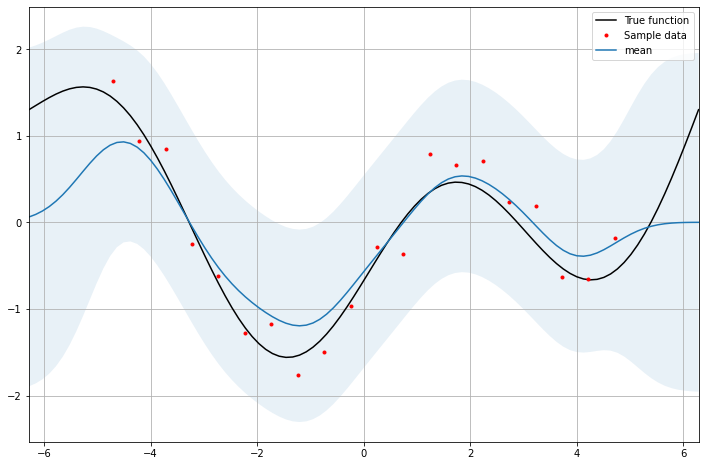

In [10]:
# Posterior distribution's mu and cov
mu, cov = predict_posterior(X=x_true.reshape(-1, 1), 
                            X_train=x_data.reshape(-1, 1), 
                            Y_train=y_data.reshape(-1, 1), 
                            l=1.0, 
                            sigma_f=1.0, 
                            sigma_y=1.0)
samples = np.random.multivariate_normal(mu.reshape(-1), cov, 0)

# Plot true function and sampled data points
plt.figure(figsize=(12, 8))
plt.plot(x_true, y_true, 'k-', label='True function')
plt.plot(x_data, y_data, 'r.', label='Sample data')
plt.legend()
plt.grid()
plt.xlim([-2*np.pi, 2*np.pi])

# Plot predictions from learning
plot_gp(mu, cov, x_true, samples)

## [STEP 5] Learning the Optimal Hyperparameter Values

Note that the parameters used, $l, \sigma_f^2, \sigma_y^2$, do not have the optimal values! <br>
We can obtain the best parameters by maximizing the log-likelihood:
\begin{equation}
\textbf{y}\sim\mathcal{N}(0, K+\sigma_y^2\mathbb{I}) \\
\log P(y\mid\textbf{X}) = 
-\frac{1}{2}\textbf{y}^T(K+\sigma_y^2\mathbb{I})^{-1}\textbf{y}
-\frac{1}{2}\log|K+\sigma_y^2\mathbb{I}|-\frac{n}{2}\log 2\pi
\end{equation}
Note that maximizing the above log-likelihood is equivalent to minimizing the following negative log-likelihood (usually denoted as NLL):
\begin{equation}
NLL = \frac{1}{2}\textbf{y}^T(K+\sigma_y^2\mathbb{I})^{-1}\textbf{y}
+\frac{1}{2}\log|K+\sigma_y^2\mathbb{I}|
\end{equation}
In order to facilitate this optimization process, we will create a class for the Gaussian process model, and using PyTorch's module, optimize via the gradient descent method.

In [11]:
class GPR():
    def __init__(self):
        self.l = torch.tensor(1e1, requires_grad=True)
        self.sigma_f = torch.tensor(1e0, requires_grad=True)
        self.sigma_y = torch.tensor(1e-4, requires_grad=True)
        self.reset()

    def reset(self):
        self.parameters = [self.l, self.sigma_f, self.sigma_y]
        self.optimizer = torch.optim.Adam(self.parameters, lr=1e-3)

    def GaussianRBF(self, X, Y):
        assert X.shape[1] == Y.shape[1] # dimension must be equal!
        m, d = X.shape
        n, d = Y.shape
        term1 = torch.sum(X**2, dim=1).view(-1, 1)
        assert term1.shape == (m, 1)
        term2 = torch.matmul(X, Y.t())
        assert term2.shape == (m, n)
        term3 = torch.sum(Y**2, dim=1).view(1, -1)
        assert term3.shape == (1, n)
        dist_matrix = term1 - 2*term2 + term3
        return (self.sigma_f**2) * torch.exp((-1/(self.l**2)) * dist_matrix)

    def predict_posterior(self, X, X_train, Y_train):
        K11 = self.GaussianRBF(X_train, X_train) + self.sigma_y**2 * torch.eye(len(X_train))
        K21 = self.GaussianRBF(X, X_train)
        K12 = self.GaussianRBF(X_train, X) # Note, K12 = K21.T (transposed)
        K22 = self.GaussianRBF(X, X)
        K11_inv = torch.linalg.inv(K11)
        mu = torch.matmul(K21, torch.matmul(K11_inv, Y_train))
        cov = K22 - torch.matmul(K21, torch.matmul(K11_inv, K12))
        return mu, cov

    def set_hyperparameter(self, l, sigma_f, sigma_y):
        self.l = torch.tensor(l, requires_grad=True)
        self.sigma_f = torch.tensor(sigma_f, requires_grad=True)
        self.sigma_y = torch.tensor(sigma_y, requires_grad=True)
        self.reset()

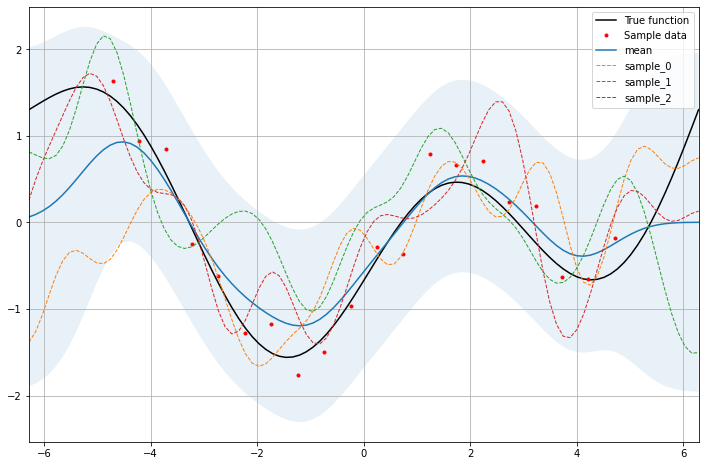

In [12]:
# Sanity check!

gpr = GPR()
l, sigma_f, sigma_y = 1.0, 1.0, 1.0
gpr.set_hyperparameter(l, sigma_f, sigma_y)
X_tensor = torch.from_numpy(x_true.reshape(-1, 1))
X_train_tensor = torch.from_numpy(x_data.reshape(-1, 1))
Y_train_tensor = torch.from_numpy(y_data.reshape(-1, 1))
mu, cov = gpr.predict_posterior(X_tensor, X_train_tensor, Y_train_tensor)
mu = mu.detach().numpy()
cov = cov.detach().numpy()
samples = np.random.multivariate_normal(mu.reshape(-1), cov, 3)

# Plot true function and sampled data points
plt.figure(figsize=(12, 8))
plt.plot(x_true, y_true, 'k-', label='True function')
plt.plot(x_data, y_data, 'r.', label='Sample data')
plt.legend()
plt.grid()
plt.xlim([-2*np.pi, 2*np.pi])

# Plot predictions from learning
plot_gp(mu, cov, x_true, samples)

Recall, we need to minimize the following:
\begin{equation}
NLL = \frac{1}{2}\textbf{y}^T(K+\sigma_y^2\mathbb{I})^{-1}\textbf{y}
+\frac{1}{2}\log|K+\sigma_y^2\mathbb{I}|
\end{equation}

In [13]:
# Optimize parameters
gpr.set_hyperparameter(1.0, 1.0, 1.0)
X_tensor = torch.from_numpy(x_true.reshape(-1, 1))
X_train_tensor = torch.from_numpy(x_data.reshape(-1, 1))
Y_train_tensor = torch.from_numpy(y_data.reshape(-1, 1))

for i in range(5000):
    K = gpr.GaussianRBF(X_train_tensor, X_train_tensor)
    K = K + ((gpr.sigma_y+1e-10)**2) * torch.eye(len(X_train_tensor))
    ###### TO IMPLEMENT ######
    loss = Y_train_tensor.T @ torch.inverse(K) @ Y_train_tensor + torch.log(torch.det(K))
    ##########################
    gpr.optimizer.zero_grad()
    loss.backward()
    gpr.optimizer.step()
    if (i+1)%200 == 0:
        print('Iter[{}/5000]\tloss:{:.4f}\tl:{:.4f}\tsigma_f:{:.4f}\tsigma_y:{:.4f}'.format(i+1, loss.item(), gpr.l.item(), gpr.sigma_f.item(), gpr.sigma_y.item()))

Iter[200/5000]	loss:8.8395	l:1.1926	sigma_f:0.8225	sigma_y:0.7923
Iter[400/5000]	loss:1.1659	l:1.3794	sigma_f:0.7577	sigma_y:0.5677
Iter[600/5000]	loss:-7.2765	l:1.5865	sigma_f:0.8052	sigma_y:0.3422
Iter[800/5000]	loss:-9.6780	l:1.7958	sigma_f:0.8649	sigma_y:0.2629
Iter[1000/5000]	loss:-10.2775	l:1.9558	sigma_f:0.9172	sigma_y:0.2598
Iter[1200/5000]	loss:-10.6103	l:2.0793	sigma_f:0.9632	sigma_y:0.2582
Iter[1400/5000]	loss:-10.7986	l:2.1764	sigma_f:1.0035	sigma_y:0.2572
Iter[1600/5000]	loss:-10.9031	l:2.2523	sigma_f:1.0380	sigma_y:0.2566
Iter[1800/5000]	loss:-10.9593	l:2.3108	sigma_f:1.0664	sigma_y:0.2562
Iter[2000/5000]	loss:-10.9882	l:2.3550	sigma_f:1.0889	sigma_y:0.2560
Iter[2200/5000]	loss:-11.0023	l:2.3874	sigma_f:1.1060	sigma_y:0.2558
Iter[2400/5000]	loss:-11.0087	l:2.4104	sigma_f:1.1185	sigma_y:0.2557
Iter[2600/5000]	loss:-11.0114	l:2.4260	sigma_f:1.1272	sigma_y:0.2557
Iter[2800/5000]	loss:-11.0124	l:2.4362	sigma_f:1.1329	sigma_y:0.2557
Iter[3000/5000]	loss:-11.0127	l:2.4425	sigma

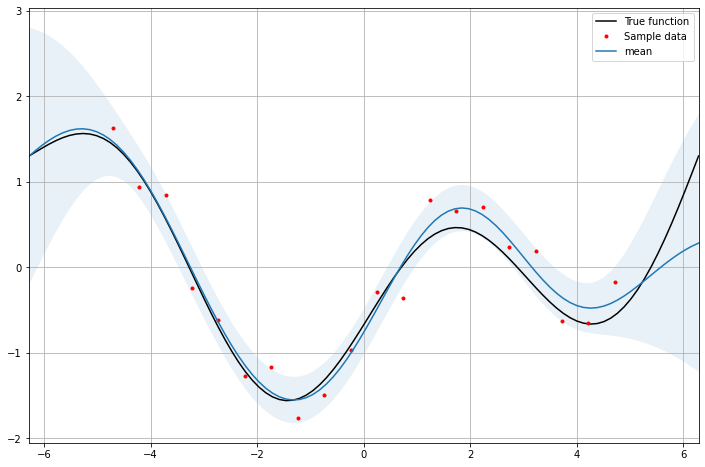

In [14]:
# Plot with optimized model!
mu, cov = gpr.predict_posterior(X_tensor, X_train_tensor, Y_train_tensor)
mu = mu.detach().numpy()
cov = cov.detach().numpy()
samples = np.random.multivariate_normal(mu.reshape(-1), cov, 0)

# Plot true function and sampled data points
plt.figure(figsize=(12, 8))
plt.plot(x_true, y_true, 'k-', label='True function')
plt.plot(x_data, y_data, 'r.', label='Sample data')
plt.legend()
plt.grid()
plt.xlim([-2*np.pi, 2*np.pi])

# Plot predictions from learning
plot_gp(mu, cov, x_true, samples)

## [EXTRA] Easy implementation using scikit-learn package

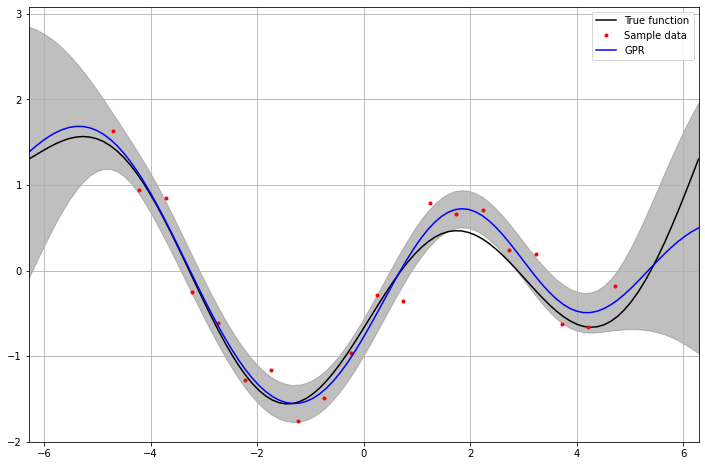

In [15]:
# Easy implementation with scikit-learn package
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, RBF

# Set initial hyperparameters
init_lambda = 10. # l
init_beta = 1. # sigma_f
init_sigma = 0.04 # sigma_y

# Initialize GaussianRBF kernel and GPR model
kernel = ConstantKernel(init_beta, (1e-3, 1e3)) * RBF(init_lambda, (1e-3, 1e3))
gp = GaussianProcessRegressor(kernel=kernel, alpha=init_sigma, n_restarts_optimizer=9)

# Reshape arrays into 2d arrays
x_gp = x_true.reshape(-1, 1)
y_gp = y_true.reshape(-1, 1)
X_train_gp = x_data.reshape(-1, 1)
Y_train_gp = y_data.reshape(-1, 1)

# Optimize parameters and obtain results
gp.fit(X_train_gp, Y_train_gp)
Y_pred_sk, std_pred_sk = gp.predict(x_gp, return_std=True)
Y_pred_sk = Y_pred_sk.flatten()
std_pred_sk = std_pred_sk.flatten()

# Plot results
plt.figure(figsize=(12, 8))
plt.plot(x_true, y_true, 'k-', label='True function')
plt.plot(x_data, y_data, 'r.', label='Sample data')
plt.plot(x_true, Y_pred_sk, 'b-', label='GPR')
plt.fill_between(x_true, Y_pred_sk-1.96*std_pred_sk, Y_pred_sk+1.96*std_pred_sk, color='grey', alpha=0.5)
plt.legend()
plt.grid()
plt.xlim([-2*np.pi, 2*np.pi])
plt.show()